# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [1]:
import os
import random
import shutil
from tqdm import tqdm

# To create the same dataset
random.seed(0)

Use the GPU accelerator if you can.

In [2]:
# Path to dataset
base = '/kaggle/input/flowers-recognition'
splits = '/kaggle/input/flower-split'

In [3]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(splits, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'rose', 'dandelion', 'sunflower', 'flowers', 'tulip']


['/kaggle/input/flowers-recognition/flowers/daisy',
 '/kaggle/input/flowers-recognition/flowers/rose',
 '/kaggle/input/flowers-recognition/flowers/dandelion',
 '/kaggle/input/flowers-recognition/flowers/sunflower',
 '/kaggle/input/flowers-recognition/flowers/flowers',
 '/kaggle/input/flowers-recognition/flowers/tulip']

We build the (image, label) pairs

In [4]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('2509545845_99e79cb8a2_n.jpg', 'daisy'),
 ('34729724865_787c98299d_n.jpg', 'daisy'),
 ('909609509_a05ccb8127.jpg', 'daisy'),
 ('134409839_71069a95d1_m.jpg', 'daisy'),
 ('2642408410_61545fdc83_n.jpg', 'daisy'),
 ('4496202781_1d8e776ff5_n.jpg', 'daisy'),
 ('299129811_d6ebda9970.jpg', 'daisy'),
 ('5896103923_075a988bed_n.jpg', 'daisy'),
 ('14147016029_8d3cf2414e.jpg', 'daisy'),
 ('5714327423_50af0cffe9.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [5]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

EPOCHS = 50
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

### Create the network and compile it

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(5, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5, epsilon=1e-08),
              metrics=['acc'])

Create now the data generators for the training, validation, and test set

In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')                        

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=1,
        shuffle=False)


Found 2592 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


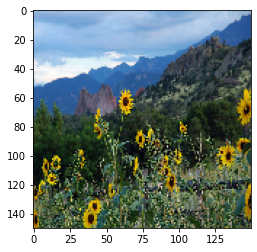

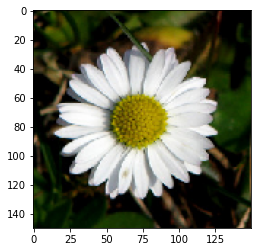

In [10]:
# See some images
x,y = train_generator.next()
for i in range(0,2):
    image = x[i]
    plt.imshow(image)
    plt.show()

Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [11]:
STEPS_PER_EPOCH = 100 # Every Epoch runs through a number of batches
VALIDATION_STEPS = 25 # Breaks loop since we pass a generator in out fit function later

And fit your model

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)

Epoch 1/50
100/100 [==============================] - 12s 124ms/step - loss: 1.5896 - acc: 0.2495 - val_loss: 1.5784 - val_acc: 0.2280
Epoch 2/50
100/100 [==============================] - 9s 90ms/step - loss: 1.5430 - acc: 0.3173 - val_loss: 1.5301 - val_acc: 0.3100
Epoch 3/50
100/100 [==============================] - 8s 81ms/step - loss: 1.4909 - acc: 0.3911 - val_loss: 1.4605 - val_acc: 0.4340
Epoch 4/50
100/100 [==============================] - 8s 82ms/step - loss: 1.4233 - acc: 0.4423 - val_loss: 1.3997 - val_acc: 0.4260
Epoch 5/50
100/100 [==============================] - 9s 94ms/step - loss: 1.3570 - acc: 0.4585 - val_loss: 1.3569 - val_acc: 0.4580
Epoch 6/50
100/100 [==============================] - 8s 83ms/step - loss: 1.3015 - acc: 0.4834 - val_loss: 1.2819 - val_acc: 0.4880
Epoch 7/50
100/100 [==============================] - 8s 82ms/step - loss: 1.2427 - acc: 0.4980 - val_loss: 1.2215 - val_acc: 0.5040
Epoch 8/50
100/100 [==============================] - 8s 77ms/step 

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

In [13]:
model.save('flowers_no_augment.h5')

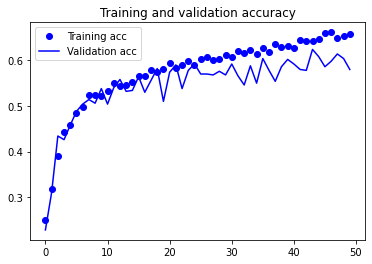

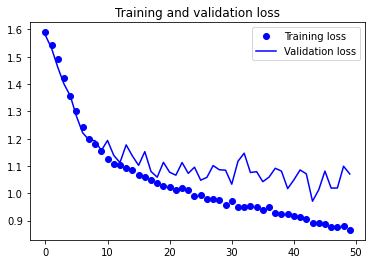

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [15]:
predict = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

865/865 [==============================] - 5s 5ms/step


In [16]:
y_true = (test_generator.classes)
y_pred = np.argmax(predict,axis=-1)

Report the accuracy as well as the classification report. Use sklearn functions

In [17]:
correct_label = np.equal(y_true, y_pred)
accuracy = np.mean(correct_label)

print('Accuracy is: ',accuracy)

Accuracy is:  0.6242774566473989


In [18]:
print("Classification report:\n%s"
      % (classification_report(y_true, y_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       174
           1       0.58      0.82      0.68       217
           2       0.68      0.48      0.56       151
           3       0.59      0.69      0.64       133
           4       0.67      0.54      0.59       190

    accuracy                           0.62       865
   macro avg       0.64      0.62      0.62       865
weighted avg       0.64      0.62      0.62       865



Print the confusion matrix

In [19]:
print("Confusion matrix:\n%s" % confusion_matrix(y_true, y_pred))

Confusion matrix:
[[ 95  58   2  11   8]
 [ 10 178   0  24   5]
 [ 12  25  73   9  32]
 [  6  27   2  92   6]
 [ 16  21  31  20 102]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [20]:
evaluation1 = model.evaluate(test_generator)
test_loss_1 = evaluation1[0]
test_acc_1 = evaluation1[1]

865/865 [==============================] - 4s 4ms/step - loss: 0.9869 - acc: 0.6243


Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [21]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2592 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')                        

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=1,
        shuffle=False)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=25)

Found 866 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Epoch 1/50
100/100 [==============================] - 20s 199ms/step - loss: 1.4157 - acc: 0.3474 - val_loss: 1.2791 - val_acc: 0.4480
Epoch 2/50
100/100 [==============================] - 21s 206ms/step - loss: 1.2326 - acc: 0.4608 - val_loss: 1.1494 - val_acc: 0.5420
Epoch 3/50
100/100 [==============================] - 21s 205ms/step - loss: 1.1708 - acc: 0.5155 - val_loss: 1.1104 - val_acc: 0.5840
Epoch 4/50
100/100 [==============================] - 21s 207ms/step - loss: 1.1297 - acc: 0.5301 - val_loss: 1.1203 - val_acc: 0.5780
Epoch 5/50
100/100 [==============================] - 21s 213ms/step - loss: 1.0865 - acc: 0.5622 - val_loss: 1.1524 - val_acc: 0.5700
Epoch 6/50
100/100 [==============================] - 21s 208ms/step - loss: 1.0430 - acc: 0.5873 - val_loss: 1.0381 - val_acc: 0.6180
Epoch 7/50
100/100 [==============================] - 21s 209ms/step - loss: 1.0136 - acc: 0.5894 - val_loss

In [23]:
model.save('flowers_augment.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

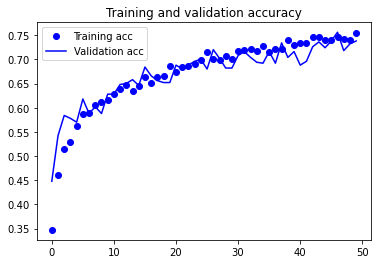

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [25]:
evaluation2 = model.evaluate(test_generator)
test_loss_2 = evaluation2[0]
test_acc_2 = evaluation2[1]

865/865 [==============================] - 5s 6ms/step - loss: 0.6928 - acc: 0.7410


## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [26]:
from keras.applications import VGG16, InceptionV3

In [27]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
#conv_base.summary()

87916544/87910968 [==============================] - 3s 0us/step


As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [28]:
BATCH_SIZE_TRAIN=20
BATCH_SIZE_VAL=20
BATCH_SIZE_TEST=1

In [29]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, batch_size, sample_count, shuffle=True):
    if PRETRAINED == 'VGG': features = np.zeros(shape=(sample_count, 4, 4, 512))
    else: features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

The features and labels

In [30]:
num_train = sum([image for image in [len(os.listdir(train_dir + "/" + cat)) for cat in os.listdir(train_dir)]])
num_val = sum([image for image in [len(os.listdir(validation_dir + "/" + cat)) for cat in os.listdir(validation_dir)]])
num_test = sum([image for image in [len(os.listdir(test_dir + "/" + cat)) for cat in os.listdir(test_dir)]])

In [31]:
train_features, train_labels = extract_features(train_dir, BATCH_SIZE_TRAIN, num_train-14)
validation_features, validation_labels = extract_features(validation_dir, BATCH_SIZE_VAL, num_val-6)
test_features, test_labels = extract_features(test_dir, BATCH_SIZE_TEST, num_test-5)

Found 2592 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [32]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [33]:
#conv_base.trainable = False
model = models.Sequential()
#model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

Fit your network

In [34]:
type(validation_labels)

numpy.ndarray

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
129/129 [==============================] - 1s 6ms/step - loss: 0.9494 - acc: 0.6477 - val_loss: 0.6871 - val_acc: 0.7605
Epoch 2/30
129/129 [==============================] - 1s 4ms/step - loss: 0.4666 - acc: 0.8442 - val_loss: 0.6668 - val_acc: 0.7570
Epoch 3/30
129/129 [==============================] - 1s 4ms/step - loss: 0.2873 - acc: 0.9027 - val_loss: 0.5694 - val_acc: 0.8105
Epoch 4/30
129/129 [==============================] - 1s 4ms/step - loss: 0.1843 - acc: 0.9504 - val_loss: 0.5865 - val_acc: 0.7965
Epoch 5/30
129/129 [==============================] - 1s 4ms/step - loss: 0.1246 - acc: 0.9713 - val_loss: 0.5604 - val_acc: 0.8023
Epoch 6/30
129/129 [==============================] - 1s 4ms/step - loss: 0.0853 - acc: 0.9849 - val_loss: 0.5484 - val_acc: 0.8221
Epoch 7/30
129/129 [==============================] - 1s 4ms/step - loss: 0.0570 - acc: 0.9919 - val_loss: 0.6348 - val_acc: 0.8093
Epoch 8/30
129/129 [==============================] - 1s 4ms/step - loss: 0.

In [36]:
model.save(f'flowers_with_{PRETRAINED}.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

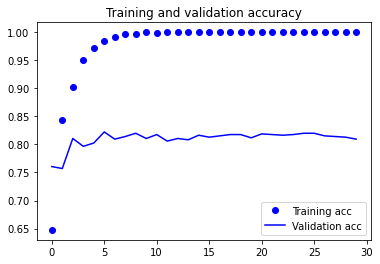

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [38]:
predict = model.predict(test_features)
y_pred = np.argmax(predict,axis=-1)
y_true = [np.argmax(x) for x in test_labels]

In [39]:
print(y_pred[:15])
print(y_true[:15])

[4 1 1 0 0 4 1 4 2 1 3 4 3 1 2]
[2, 1, 1, 3, 2, 1, 1, 4, 2, 1, 3, 4, 1, 1, 3]


Report the accuracy as well as the classification report. Use sklearn functions

In [40]:
print("Classification report:\n%s"
      % (classification_report(y_true, y_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       174
           1       0.90      0.83      0.86       215
           2       0.76      0.76      0.76       150
           3       0.77      0.80      0.79       133
           4       0.79      0.83      0.81       189

    accuracy                           0.82       861
   macro avg       0.82      0.82      0.82       861
weighted avg       0.82      0.82      0.82       861



Print the confusion matrix

In [41]:
print('Confusion matrix: \n %s' % (confusion_matrix(y_true, y_pred)))

Confusion matrix: 
 [[153   8   1   5   7]
 [ 13 178   6  13   5]
 [  3   2 114  10  21]
 [  5   6   7 107   8]
 [  3   4  22   4 156]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [42]:
evaluation3 = model.evaluate(test_features, test_labels, batch_size=1, steps=25)
test_loss_3 = evaluation3[0]
test_acc_3 = evaluation3[1]

25/25 [==============================] - 0s 3ms/step - loss: 1.5653 - acc: 0.7600


## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [43]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))

In [44]:
#conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

Create the generators

In [45]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='categorical')

Found 2592 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit the model

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
100/100 - 23s - loss: 1.2571 - acc: 0.4854 - val_loss: 0.8248 - val_acc: 0.7200
Epoch 2/30
100/100 - 24s - loss: 0.8712 - acc: 0.6682 - val_loss: 0.5883 - val_acc: 0.8000
Epoch 3/30
100/100 - 20s - loss: 0.7110 - acc: 0.7309 - val_loss: 0.3628 - val_acc: 0.8600
Epoch 4/30
100/100 - 21s - loss: 0.6251 - acc: 0.7686 - val_loss: 0.7301 - val_acc: 0.8000
Epoch 5/30
100/100 - 20s - loss: 0.5772 - acc: 0.7811 - val_loss: 0.8391 - val_acc: 0.6800
Epoch 6/30
100/100 - 24s - loss: 0.5034 - acc: 0.8175 - val_loss: 0.3773 - val_acc: 0.8800
Epoch 7/30
100/100 - 21s - loss: 0.4824 - acc: 0.8238 - val_loss: 0.4432 - val_acc: 0.8400
Epoch 8/30
100/100 - 20s - loss: 0.4224 - acc: 0.8475 - val_loss: 0.3979 - val_acc: 0.8200
Epoch 9/30
100/100 - 21s - loss: 0.4454 - acc: 0.8313 - val_loss: 0.9883 - val_acc: 0.7400
Epoch 10/30
100/100 - 24s - loss: 0.4247 - acc: 0.8454 - val_loss: 0.4232 - val_acc: 0.8400
Epoch 11/30
100/100 - 20s - loss: 0.3955 - acc: 0.8579 - val_loss: 0.2646 - val_acc: 0.90

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

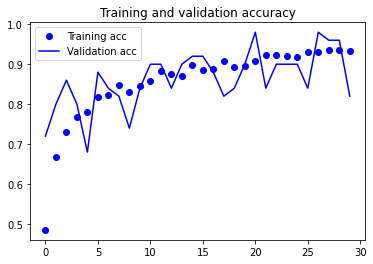

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [48]:
predict = model.predict(test_generator)
y_pred = np.argmax(predict,axis=-1)
y_true = test_generator.classes

Report the accuracy as well as the classification report. Use sklearn functions

In [49]:
print("Classification report:\n%s"
      % (classification_report(y_true, y_pred)))

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       174
           1       0.92      0.93      0.92       217
           2       0.87      0.81      0.84       151
           3       0.93      0.91      0.92       133
           4       0.84      0.91      0.87       190

    accuracy                           0.90       865
   macro avg       0.90      0.89      0.89       865
weighted avg       0.90      0.90      0.90       865



Print the confusion matrix

In [50]:
print('Confusion matrix: \n %s' % (confusion_matrix(y_true, y_pred)))

Confusion matrix: 
 [[157   8   2   3   4]
 [  6 202   3   3   3]
 [  3   3 122   2  21]
 [  1   3   3 121   5]
 [  1   4  11   1 173]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [51]:
evaluation4 = model.evaluate(test_generator)
test_loss_4 = evaluation4[0]
test_acc_4 = evaluation4[1]

865/865 [==============================] - 14s 16ms/step - loss: 0.4821 - acc: 0.8960


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [52]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((0.9868932962417603, 0.6242774724960327),
 (0.6928368210792542, 0.7410404682159424),
 (1.565332293510437, 0.7599999904632568),
 (0.4821151793003082, 0.8959537744522095))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.